In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [ ]:
# 展示mask的作用
T = 4
scores = torch.randn(1, T, T)
print(scores)
tril = torch.tril(torch.ones(T, T))
scores = scores.masked_fill(tril == 0, float('-inf'))
print(scores)
print(F.softmax(scores, dim=-1))

tensor([[[ 1.0185, -1.3091,  1.2908,  0.5276],
         [-0.2985,  1.6259,  2.0433, -0.6417],
         [ 0.8795, -1.0512,  1.1491,  0.6116],
         [ 0.2128, -0.5512,  0.0450,  0.5010]]])
tensor([[[ 1.0185,    -inf,    -inf,    -inf],
         [-0.2985,  1.6259,    -inf,    -inf],
         [ 0.8795, -1.0512,  1.1491,    -inf],
         [ 0.2128, -0.5512,  0.0450,  0.5010]]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.1274, 0.8726, 0.0000, 0.0000],
         [0.4074, 0.0591, 0.5335, 0.0000],
         [0.2743, 0.1278, 0.2319, 0.3659]]])


In [ ]:
# 展示对齐分数的方差放大效应
B, T, head_size = 32, 100, 16

k = torch.randn(B, T, head_size)  # (B, T, H)
q = torch.randn(B, T, head_size)  # (B, T, H)
scores = q @ k.transpose(-2, -1)       # (B, T, T)
print(k.std(), q.std(), scores.std())
scores = scores / head_size ** 0.5
print(k.std(), q.std(), scores.std())

# Softmax函数在处理方差较大的数据时，会发生聚集效应（结果过于集中在一个点上）
x = torch.randn(1, 8)
print(torch.softmax(x, dim=-1))
print(torch.softmax(1000 * x, dim=-1))

tensor(1.0026) tensor(1.0010) tensor(4.0152)
tensor(1.0026) tensor(1.0010) tensor(1.0038)
tensor([[0.0921, 0.1476, 0.1698, 0.4256, 0.0489, 0.0599, 0.0172, 0.0388]])
tensor([[0., 0., 0., 1., 0., 0., 0., 0.]])


In [ ]:
def attention(query, key, value, dropout, mask=None):
    # query, key, value都有相同的形状
    B, T, C = query.shape
    # (B, T, C) @ (B, C, T) --> (B, T, T)
    scores = query @ key.transpose(-2, -1) / (C ** 0.5)
    if mask is not None:
        # 如果没有mask，则表示词元可以使用左右两边的背景，也就是双向注意力
        # mask的形状是(T, T)
        scores = scores.masked_fill(mask == 0, float('-inf'))
    w_att = dropout(F.softmax(scores, dim=-1))  # (B, T, T)
    out = w_att @ value  # (B, T, C)
    return out, w_att

In [ ]:
class MaskedAttention(nn.Module):

    def __init__(self, emb_size, head_size):
        super().__init__()
        self.key = nn.Linear(emb_size, head_size, bias=False)
        self.query = nn.Linear(emb_size, head_size, bias=False)
        self.value = nn.Linear(emb_size, head_size, bias=False)
        # 这个上三角矩阵不参与模型训练
        self.register_buffer(
            'tril', torch.tril(torch.ones(sequence_len, sequence_len)))
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        B, T, C = x.shape  # C = emb_size
        q = self.query(x)  # (B, T, H)
        k = self.key(x)    # (B, T, H)
        v = self.value(x)  # (B, T, H)
        mask = self.tril[:T, :T]
        out, _ = attention(q, k, v, self.dropout, mask)
        return out         # (B, T, H)

class MaskedMultiHeadAttention(nn.Module):

    def __init__(self, emb_size, head_size):
        super().__init__()
        assert(emb_size % head_size == 0)
        n_head = emb_size // head_size
        heads = [MaskedAttention(emb_size, head_size) for _ in range(n_head)]
        self.heads = nn.ModuleList(heads)
        self.proj = nn.Linear(emb_size, emb_size)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, emb_size)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, emb_size):
        super().__init__()
        self.l1 = nn.Linear(emb_size, 4 * emb_size)
        self.l2 = nn.Linear(4 * emb_size, emb_size)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.gelu(self.l1(x))
        out = self.dropout(self.l2(x))
        return out

class Block(nn.Module):

    def __init__(self, emb_size, head_size):
        super().__init__()
        self.mha = MaskedMultiHeadAttention(emb_size, head_size)
        self.ff = FeedForward(emb_size)
        self.ln1 = nn.LayerNorm(emb_size)
        self.ln2 = nn.LayerNorm(emb_size)

    def forward(self, x):
        # 残差连接
        x = x + self.mha(self.ln1(x))
        x = x + self.ff(self.ln2(x))
        return x

In [ ]:
emb_size = 128
head_size = 8
n_layer = 12
sequence_len = 64
learning_rate = 1e-3
eval_iters = 20
batch_size=500
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
class CharGPT(nn.Module):

    def __init__(self, vs):
        super().__init__()
        self.token_embedding = nn.Embedding(vs, emb_size)
        self.position_embedding = nn.Embedding(sequence_len, emb_size)
        blocks = [Block(emb_size, head_size) for _ in range(n_layer)]
        self.blocks = nn.Sequential(*blocks)
        self.ln = nn.LayerNorm(emb_size)
        self.lm_head = nn.Linear(emb_size, vs)

    def forward(self, x):
        B, T = x.shape
        pos = torch.arange(0, T, dtype=torch.long, device=x.device)
        tok_emb = self.token_embedding(x)       # (B, T,  C)
        pos_emb = self.position_embedding(pos)  # (   T,  C)
        x = tok_emb + pos_emb                   # (B, T,  C)
        x = self.blocks(x)                      # (B, T,  C)
        x = self.ln(x)                          # (B, T,  C)
        logits = self.lm_head(x)                # (B, T, vs)
        return logits

In [ ]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

class char_tokenizer:

    def __init__(self, data):
        # 数据中出现的所有字符构成字典
        chars = sorted(list(set(''.join(data))))
        # 预留一个位置给结尾的特殊字符
        self.char2ind = {s : i + 1 for i, s in enumerate(chars)}
        self.char2ind['<|e|>'] = 0
        self.ind2char = {i : s for s, i in self.char2ind.items()}

    def encode(self, text):
        return [self.char2ind[c] for c in text]

    def decode(self, enc):
        if isinstance(enc, int):
            return self.ind2char[enc]
        return [self.ind2char[i] for i in enc]

tok = char_tokenizer(datasets['whole_func_string'])
len(tok.char2ind)

98

In [ ]:
model = CharGPT(len(tok.char2ind)).to(device)
print(f'{sum(p.numel() for p in model.parameters())} parameters')
model

2408290 parameters


CharGPT(
  (token_embedding): Embedding(98, 128)
  (position_embedding): Embedding(64, 128)
  (blocks): Sequential(
    (0): Block(
      (mha): MaskedMultiHeadAttention(
        (heads): ModuleList(
          (0-15): 16 x MaskedAttention(
            (key): Linear(in_features=128, out_features=8, bias=False)
            (query): Linear(in_features=128, out_features=8, bias=False)
            (value): Linear(in_features=128, out_features=8, bias=False)
            (dropout): Dropout(p=0.4, inplace=False)
          )
        )
        (proj): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (ff): FeedForward(
        (l1): Linear(in_features=128, out_features=512, bias=True)
        (l2): Linear(in_features=512, out_features=128, bias=True)
        (dropout): Dropout(p=0.4, inplace=False)
      )
      (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ln2): LayerNorm((128,), eps=1e-05, elementwise_affin

In [ ]:
@torch.no_grad()
def generate_batch(model, idx, max_new_tokens=300):
    # 将模型切换至评估模式
    model.eval()
    for _ in range(max_new_tokens):
        # 限制背景长度，否则会报错
        context = idx[:, -sequence_len:]
        logits = model(context)
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, ix), dim=1)
        if ix.item() == 0:
            break
    # 将模型切换至训练模式
    model.train()
    return idx.tolist()[0]

In [ ]:
begin_text = torch.tensor(tok.encode('def'), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def* O(h/of("YP`soE f|dwöR:1'_v?Q9)Nsx/Q=CKf\M:iKcaI%+Q3m<sAegWSJ?0Nx!qJT3\yMm5Za)'W*N\WmsB?({<|e|>


In [ ]:
def process(data, sequence_len=sequence_len):
    text = data['whole_func_string']
    inputs, labels = [], []
    for i in text:
        enc = tok.encode(i)
        enc += [0]
        for i in range(len(enc) - sequence_len):
            inputs.append(enc[i: i + sequence_len])
            labels.append(enc[i + 1: i + 1 + sequence_len])
    return {'inputs': inputs, 'labels': labels}

tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)
tokenized = tokenized.map(process, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape

(torch.Size([605913, 64]), torch.Size([605913, 64]))

In [ ]:
# 构建数据读取器
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)
# 获取一个批量的数据
next(iter(test_loader))

{'inputs': tensor([[ 2,  2,  2,  ...,  2,  2,  4],
         [81, 80, 88,  ...,  2,  2, 10],
         [ 4, 37, 84,  ...,  2,  2,  2],
         ...,
         [75, 85,  2,  ..., 70, 71, 84],
         [ 2,  2,  2,  ..., 67, 78, 53],
         [87, 84, 67,  ..., 89,  2, 38]], device='cuda:0'),
 'labels': tensor([[ 2,  2, 32,  ...,  2,  4,  4],
         [80, 88, 71,  ...,  2, 10, 70],
         [37, 84, 71,  ...,  2,  2,  2],
         ...,
         [85,  2, 72,  ..., 71, 84, 75],
         [ 2,  2,  2,  ..., 78, 53, 81],
         [84, 67, 86,  ...,  2, 38, 53]], device='cuda:0')}

In [ ]:
def estimate_loss(model):
    re = {}
    # 将模型切换至评估模式
    model.eval()
    re['train'] = _loss(model, train_loader)
    re['test'] = _loss(model, test_loader)
    # 将模型切换至训练模式
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader):
    """
    计算模型在不同数据集下面的评估指标
    """
    loss = []
    data_iter= iter(data_loader)
    for k in range(eval_iters):
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(data_loader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)
        logits = logits.transpose(-2, -1)
        loss.append(F.cross_entropy(logits, labels).item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 4.730087757110596, 'test': 4.726046562194824}

In [ ]:
def train_gpt(model, optimizer, data_loader, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(data_loader, 0):
            inputs, labels = data['inputs'], data['labels']
            optimizer.zero_grad()
            logits = model(inputs)
            logits = logits.transpose(-2, -1)
            loss = F.cross_entropy(logits, labels)
            lossi.append(loss.item())
            loss.backward()
            optimizer.step()
        # 评估模型，并输出结果
        stats = estimate_loss(model)
        train_loss = f'train loss {stats["train"]:.4f}'
        test_loss = f'test loss {stats["test"]:.4f}'
        print(f'epoch {epoch:>2}: {train_loss}, {test_loss}')
    return lossi

In [16]:
l = train_gpt(model, optim.AdamW(model.parameters(), lr=learning_rate), train_loader)

epoch  0: train loss 0.9037, test loss 1.1066
epoch  1: train loss 0.7246, test loss 1.0086
epoch  2: train loss 0.6448, test loss 0.9719
epoch  3: train loss 0.5838, test loss 0.9607
epoch  4: train loss 0.5468, test loss 0.9672
epoch  5: train loss 0.5156, test loss 0.9663
epoch  6: train loss 0.4891, test loss 0.9596
epoch  7: train loss 0.4687, test loss 0.9652
epoch  8: train loss 0.4517, test loss 0.9709
epoch  9: train loss 0.4347, test loss 0.9761


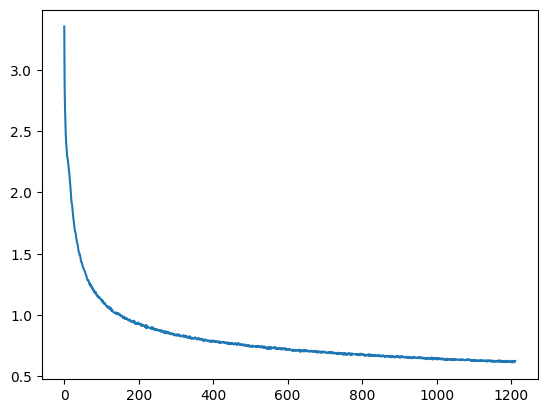

In [17]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [18]:
begin_text = torch.tensor(tok.encode('def '), device=device).unsqueeze(0)
print(''.join(tok.decode(generate_batch(model, begin_text))))

def _initialModel._to_java_impl():
        """
        Deprecated in 2.3.0. Use :func:`pyspark.sql.types.DataType`, int or :class:`Column` expression in the given key (default param).

        >>> df = spark.range(1, 0).alias('age')).collect()
        [Row(name=u'Alice', age=1, name=u'Alice')]
        "
